# Vertical Slice Demonstration: LeaveLens Model

## Introduction

This notebook presents a single end-to-end vertical slice demonstrating how the LeaveLens model processes a document. The workflow covers input image annotation, model inference, and structured data extraction, providing a clear view of how each component of the pipeline fits together.

## Model Pipeline Overview

1. **Document Input**  
   The pipeline begins with a document PDF.

2. **OCR with Amazon Textract**  
   The PDF is processed using Amazon Textract, which performs OCR and produces a raw JSON file containing text and layout information.

3. **Data Conversion and Formatting**  
   The Textract JSON output is transformed into a structured format that the LeaveLens model can understand, including tokens, bounding boxes, and page-level inputs.

4. **Model Inference**  
   The formatted data is passed through the model, which predicts an output label for each token.

5. **Structured Output**  
   The model’s token-level predictions are decoded and saved as a structured JSON file for downstream use.

## End-to-End Demonstration

Load dependencies, setup notebook path, initilize file paths, and seed for reproducibility

In [3]:
import json
import random
import sys, subprocess
from pathlib import Path
from typing import Dict, List, Optional

# notebook path setup
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

from docfusion_lite.data.textracttest import build_label_maps, textract_detect_to_page_samples
from docfusion_lite.data.dataset import DocumentDataset, make_collate_fn
from docfusion_lite.models.docfusion_model import DocFusionModel

from scripts.verticalslice import (
    seed_all,
    freeze_module,
    move_batch_to_device,
    overlay_annotations,
    tokens_to_word_tags,
    bio_decode_spans,
    write_prediction_json,
    overlay_predictions,
)


subprocess.check_call([
    sys.executable, "-m", "pip", "install", "-U",
    "protobuf", "tiktoken", "sentencepiece"
])


seed_all(7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


textract_json_path = ROOT / "docfusion_lite" / "data" / "textracttest" / "out_detect_hw.json"
img_path = ROOT / "docfusion_lite" / "data" / "textracttest" / "form-wh-380-e-813x1024-hw.jpg"

OUT_DIR = ROOT / "scripts" / "textractoutput"
OUT_DIR.mkdir(parents=True, exist_ok=True)
out_path = OUT_DIR / "annotated_page1.jpg"

We begin with a synthetic FMLA document image. This represents the raw unstructured data our system would recieve in practice.

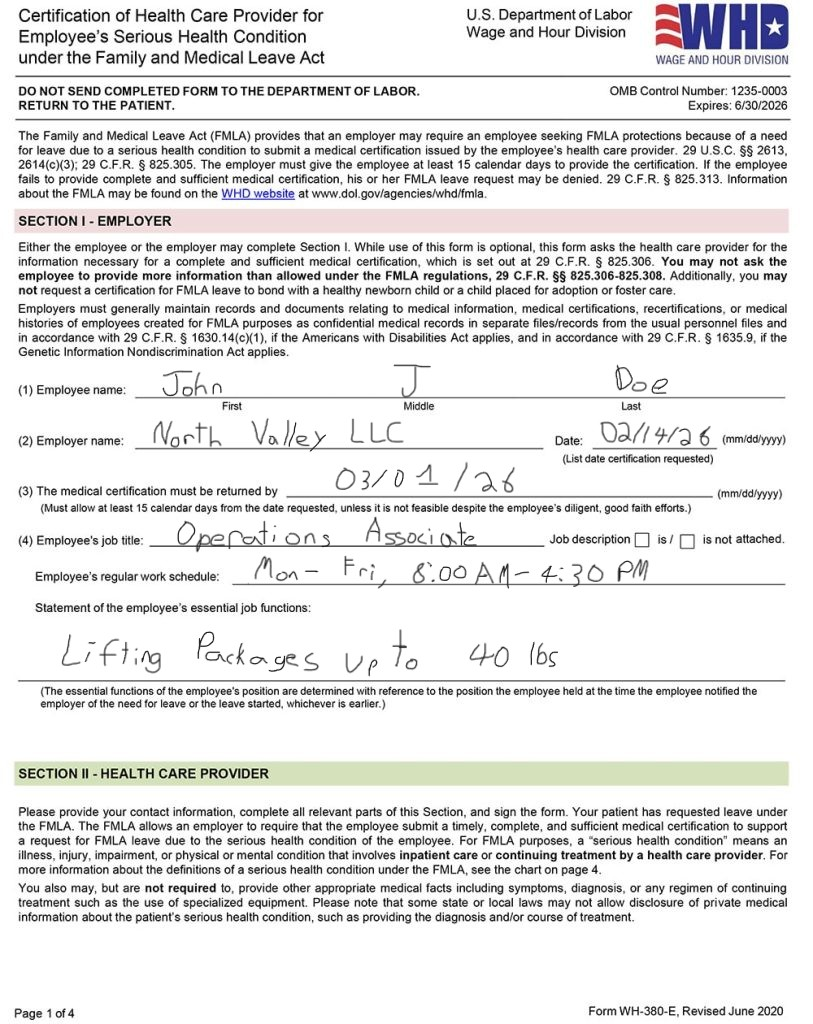

In [4]:
img = Image.open(img_path)
display(img)

After loading the image, we pass it through Amazon Textract. This outputs a large JSON file that contains:
- A list of OCR “Blocks” (e.g., `LINE`, `WORD`, and other document elements)
- Extracted text for each block and basic text metadata (e.g., `TextType`)
- Normalized geometric information
- Confidence scores per detected block (`Confidence`)
- Document structure metadata

In [5]:
blocks = json.loads(textract_json_path.read_text())["Blocks"]
words = [b for b in blocks if b.get("BlockType") == "WORD"][:3]
print(json.dumps(words, indent=2))

[
  {
    "BlockType": "WORD",
    "Confidence": 99.96014404296875,
    "Text": "Certification",
    "TextType": "PRINTED",
    "Geometry": {
      "BoundingBox": {
        "Width": 0.1130954697728157,
        "Height": 0.014164499938488007,
        "Left": 0.023435261100530624,
        "Top": 0.008325690403580666
      },
      "Polygon": [
        {
          "X": 0.023435361683368683,
          "Y": 0.008326482959091663
        },
        {
          "X": 0.13653072714805603,
          "Y": 0.008325690403580666
        },
        {
          "X": 0.13653062283992767,
          "Y": 0.022489404305815697
        },
        {
          "X": 0.023435261100530624,
          "Y": 0.022490190342068672
        }
      ]
    },
    "Id": "16aa036d-a7af-402f-988b-3541a16c2444"
  },
  {
    "BlockType": "WORD",
    "Confidence": 99.931640625,
    "Text": "of",
    "TextType": "PRINTED",
    "Geometry": {
      "BoundingBox": {
        "Width": 0.019728252664208412,
        "Height": 0.01379597

This raw Textract output is not directly compatible with our model so we convert into a model-readable structure. 
We perform this conversion using a helper function implemented in `docfusion_lite/data/textracttest.py`.

In [6]:
samples = textract_detect_to_page_samples(
    textract_json_path=textract_json_path,
    image_paths_by_page={1: img_path},
    default_label="O",
    image_path_in_sample="absolute",
)

We can overlay the extracted OCR annotations directly onto the original document image.  
This visualization shows exactly what the OCR system produced and, by extension, what our model “sees” as input.

Annotated image saved as c:\Users\luke6\Desktop\DocFusionLite\scripts\textractoutput\annotated_page1.jpg


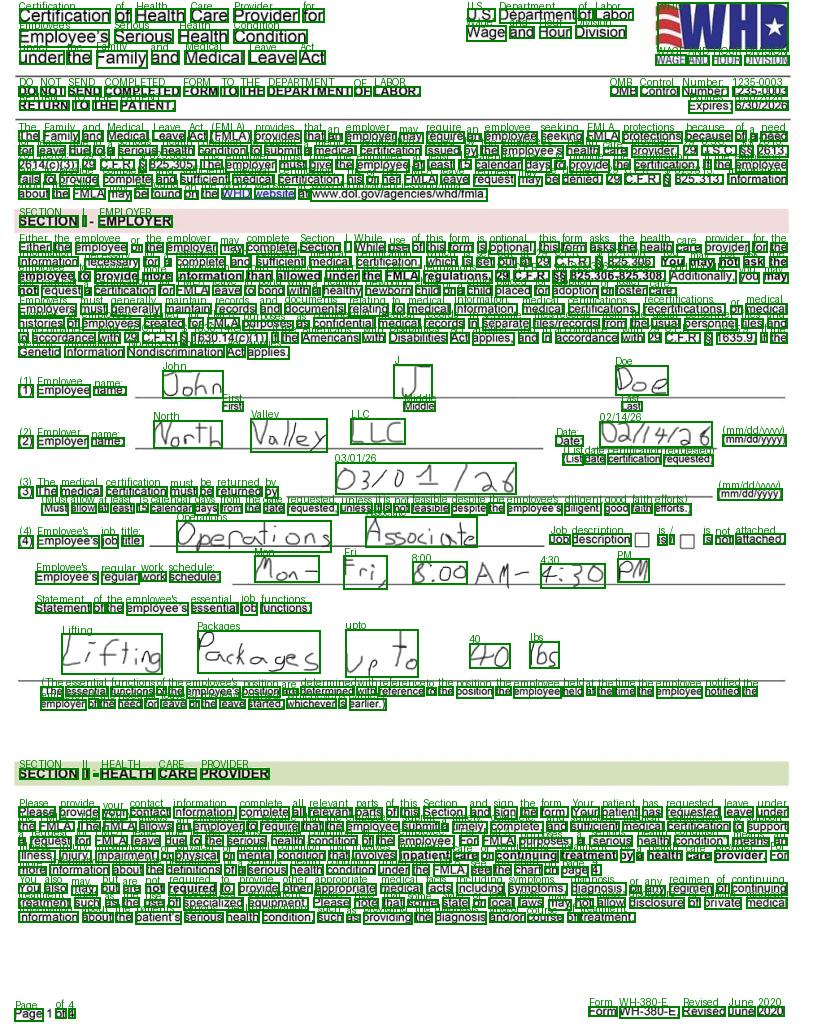

In [7]:
[s0] = samples  
overlay_annotations(
    image_path=s0["image_path"],
    words=s0["words"],
    bboxes=s0["bboxes"],
    output_path=out_path,  
)
img = Image.open("../scripts/textractoutput/annotated_page1.jpg")
display(img)

> *Overall, the OCR performs relatively well on this document. It correcntly identifies most printed text and handwriting even when the handwriting quality is poor.*

> *One minor error is visible: the OCR fails to capture the “AM” token following the start time.*

> *Further investigation is needed to determine whether it is a one-off error or something more serious. As more documents are processed and additional data is collected, we can better characterize these edge cases and apply targeted improvements to the OCR and preprocessing pipeline as needed.*

We preprocess OCR samples into a model-ready batch and move it to the active device for inference.

In [8]:
label2id,_ = build_label_maps()

ds = DocumentDataset(
    samples = samples,
    label2id = label2id,
    image_root = None,
    image_size=224,
    max_length=192,
)
collate_fn = make_collate_fn(pad_token_id=ds.tokenizer.pad_token_id)
dl = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)
batch = next(iter(dl))
batch = move_batch_to_device(batch, device)

c:\Users\luke6\anaconda3\envs\multimodal\lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


We instantiate the DocFusion-Lite model in 3.1 configuration, using lightweight settings to keep this vertical-slice example minimal.

Finally, we run a forward pass under `torch.no_grad()` to perform inference and obtain token-level logits for the batch.

In [ ]:
model = DocFusionModel(
    mode="3.1",
    num_fusion_layers=0,
    num_encoder_layers=2,
    num_labels=len(label2id),
    dropout=0.0,
    use_gate_stem=False,
    use_gate_fusion_layer=False,
    use_region_ffn=True,
    text_model_name="microsoft/deberta-v3-base",
    vision_model_name="microsoft/dit-base",
).to(device)

# Load trained model weights
checkpoint_path = ROOT / "checkpoints" / "ckpt.pt"
if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model"])
    print("Loaded model checkpoint.")
else:
    print("No checkpoint found, using untrained model.")

model.text_encoder.freeze_all()
model.vision_encoder.freeze_all()

with torch.no_grad():
    logits = model(batch)

Some weights of BeitModel were not initialized from the model checkpoint at microsoft/dit-base and are newly initialized: ['pooler.layernorm.bias', 'pooler.layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of BeitModel were not initialized from the model checkpoint at microsoft/dit-base and are newly initialized: ['pooler.layernorm.bias', 'pooler.layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: Error(s) in loading state_dict for DocFusionModel:
	size mismatch for token_head.weight: copying a param with shape torch.Size([7, 768]) from checkpoint, the shape in current model is torch.Size([9, 768]).
	size mismatch for token_head.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([9]).

We convert token-level predictions back to word-level tags using `tokens_to_word_tags`, implemented in `docfusion_lite/data/textracttest.py`, aligning model outputs with the original OCR words from the Textract file. We then overlay the predicted labels on the document image to visualize the model’s extractions.

Pred overlay saved: c:\Users\luke6\Desktop\DocFusionLite\scripts\textractoutput\pred_overlay_page1.jpg


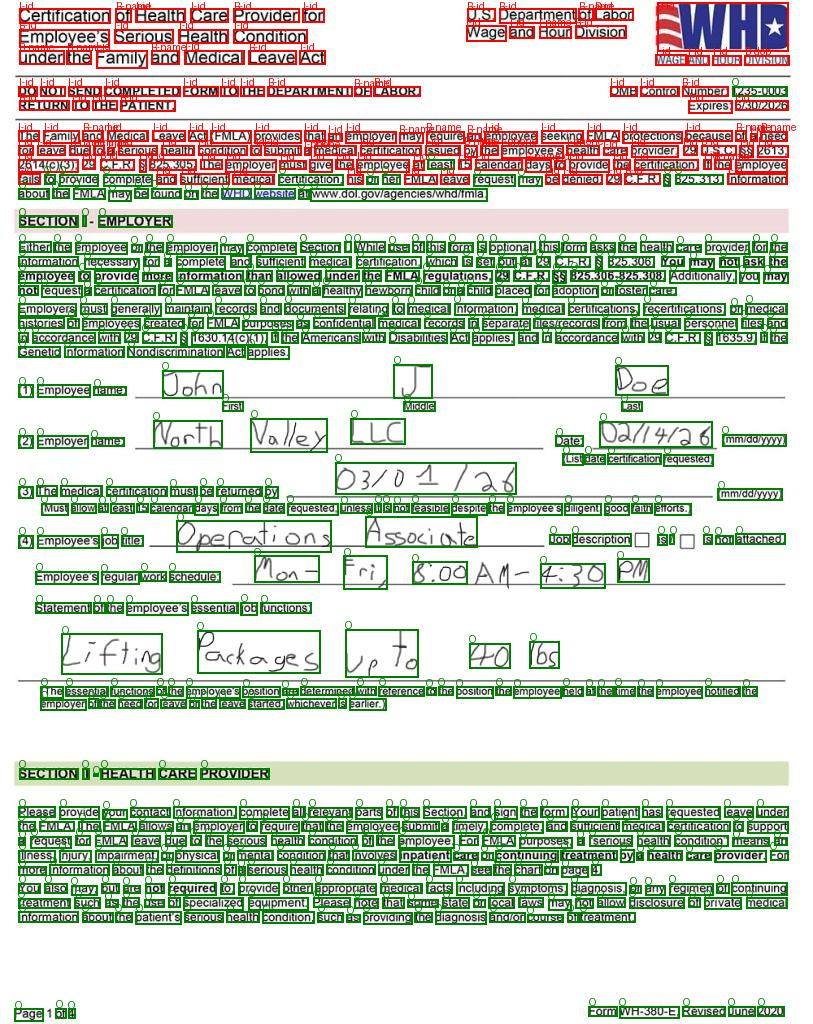

In [10]:
pred_token_ids = logits.argmax(dim=-1)[0].detach().cpu().tolist()  # (T,)


_, id2label = build_label_maps()
pred_word_ids = tokens_to_word_tags(ds.tokenizer, s0["words"], pred_token_ids, max_length=ds.max_length)
pred_word_tags = [id2label[i] for i in pred_word_ids]

out_pred = OUT_DIR / "pred_overlay_page1.jpg"
overlay_predictions(
    image_path=s0["image_path"],
    words=s0["words"],
    bboxes=s0["bboxes"],
    word_tags=pred_word_tags,
    output_path=out_pred,
    draw_all=False,  
)
img = Image.open(out_pred)
display(img)

During inference, the model produces a tag prediction for each OCR word on the page. At this stage, every token has an associated label indicating whether it belongs to a specific field (e.g., `B-name`, `I-name`) or to no field (`O`).Because the model has not yet been trained, the predicted labels are uninformative. 

We finally convert the model’s predictions into a structured JSON file.


In [11]:
doc_id = Path(s0["image_path"]).stem
extracted = bio_decode_spans(s0["words"], pred_word_tags)
write_prediction_json(
    out_path=OUT_DIR / "predictions_page1.json",
    doc_id=doc_id,
    page_num=int(s0.get("page", 1)),
    words=s0["words"],
    tags=pred_word_tags,
    extracted=extracted, )

wrote json: c:\Users\luke6\Desktop\DocFusionLite\scripts\textractoutput\predictions_page1.json


 Because the model is not yet trained, the extracted fields are currently incorrect and noisy, which is expected. In production, this same JSON format will contain accurate, structured data that can be used for downstream workflows and system integration.

In [18]:
out_path = OUT_DIR / "predictions_page1.json"
data = json.loads(out_path.read_text())

extracted = data["extracted"]
for field, spans in extracted.items():
    print(field, "->", spans[:30])

name -> ['of', 'of', 'Hour', 'the', 'and', 'under', 'OF', 'and', 'of', 'need', 'an', 'require', 'may', 'due', 'to', 'by', 'the', 'days']
id -> ['Labor', 'U.S.', 'Provider for Care Certification Health', 'Department', 'WHD', 'Division', 'and Wage Serious Health Condition', "Employee's", 'Medical', 'Leave', 'Act Family HOUR WAGE AND', 'Number: Control OMB', 'DEPARTMENT THE FORM NOT TO SEND COMPLETED', 'LABOR. DO', 'TO 6/30/2026 THE', 'PATIENT.', 'RETURN Expires: because The', 'Medical that', 'FMLA Leave Act', 'Family', 'an', 'seeking provides (FMLA) employer employee protections a', 'for issued health', 'certification submit condition leave the serious', 'U.S.C. 29 medical to', '2613,', 'provider.', 'care a $$', 'If the 15 The', 'C.F.R. 29 825.305. the']
dob -> ['DIVISION']
phone -> ['health', 'a', "employee's"]



Once trained, this is what an output could look like

- `name -> ["John Doe"]`
- `employer -> ["North Valley LLC"]`
- `date -> ["02/14/26"]`
- `job_title -> ["Operations Associate"]`
- `work_schedule -> ["Mon–Fri 8:00 AM–4:30 PM"]`
- `essential_functions -> ["Lifting packages up to 40 lbs"]`

